Predicting Movie Success

CS 109A Final Project

Nicholas Tarantino

Elizabeth Yemane

First, we import necessary libraries.

In [28]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Let's load our dataset and drop variables we will not be using.

In [4]:
# load dataset
data = pd.read_csv('movie_metadata.csv', delimiter=',')

# remove unnecessary columns
del data['movie_imdb_link']
del data['plot_keywords']

Genres are stored as one string "genre1|genre2|..." for each movie. We expand these strings so that each genre is a variable. We also use one hot encoding to encode categorical variables. Finally, all data that is missing revenue data (our response variable) is not used.

In [5]:
# movies with no revenue data
no_rev = np.isnan(data.gross).values
print str(sum(no_rev)) + " movies have no revenue data."

# get different genres
genres = data.genres.values[~no_rev]
uniq_gen = []
for genre in genres:
    diff_genres = genre.split("|")
    for i in diff_genres:
        if i not in uniq_gen:
            uniq_gen.append(i)

# drop genre column so we can encode it later
del data['genres']

# split data into predictors and response
x = data.loc[~no_rev, data.columns != 'gross']
y = data.loc[~no_rev, data.columns == 'gross']

# number of predictors
n_preds = x.shape[1]

# expanded data frame
x_exp = pd.DataFrame({})

# add placeholders for genre
for genre in uniq_gen:
    x_exp[genre] = np.nan

# numerical variables that are categorical
categorical = ["facenumber_in_poster", "title_year", "aspect_ratio"]

# iterate over variables and encode if categorical as in lecture 7
for col in x.columns:
    
    if(x[col].dtype != np.dtype("object")):
        x_exp = pd.concat([x_exp, x[col]], axis=1)
        
    elif col in categorical:
        # encode
        enc = pd.get_dummies(x[col])
        x_exp = pd.concat([x_exp, enc], axis=1)
    
    else:
        # encode
        enc = pd.get_dummies(x[col])
        x_exp = pd.concat([x_exp, enc], axis=1)

        
print x_exp.shape[0]

# add in genre data
for i in range(x_exp.shape[0]):
    g = genres[i].split('|')
    for j in uniq_gen:
        if j in g:
            x_exp.loc[x_exp.index[i],j] = 1
            
        else:
            x_exp.loc[x_exp.index[i],j] = 0

print "Number of variables = " + str(x_exp.shape[1])

884 movies have no revenue data.
4159
Number of variables = 13007


Now, we impute missing values using the median. This makes sense for categorical values and mitigates impact of extreme values for numerical data. Using a classifier like KNN would take to long due to the massive size of the dataset.

In [6]:
# impute values
imp = preprocessing.Imputer(strategy = 'median')
imp.fit(x_exp)
pre_filled = pd.DataFrame(data = imp.transform(x_exp), columns = x_exp.columns)

To begin model building, we use a naive and simple linear regression.

In [324]:
# train and test split
x_train, x_test, y_train, y_test = train_test_split(pre_filled, y, test_size=0.3)

In [325]:
# Unweighted linear regression
lr_tit = LinearRegression()
lr_tit.fit(pre_filled, y)
lr_scre = lr_tit.score(pre_filled, y)

print "The R^2 value for LR is " + str(lr_scre)

The R^2 value for LR is 1.0


Let's see what variables are given the most weight.

In [376]:
# most weighted variables
coeffs_tit = lr_tit.coef_
abs_coeffs_tit = [np.abs(x) for x in coeffs_tit]

# 20 top coefficients
import heapq
top20_tit = heapq.nlargest(20, abs_coeffs_tit[0])

# what are the top coefficients
top_tit = []
for i in top20_tit:
    index = list(abs_coeffs_tit[0]).index(i)
    top_tit.append(pre_filled.columns[index])
    
# cut end of movie title text
final_top_tit = []
for i in top_tit:
    var = i.split('\xc2\xa0')[0]
    if var not in final_top_tit:
        final_top_tit.append(var)
        
final_top_tit
top_tit

['The Dark Knight\xc2\xa0',
 'Titanic\xc2\xa0',
 'Titanic\xc2\xa0',
 'Avatar\xc2\xa0',
 'James Cameron',
 'Jurassic World\xc2\xa0',
 'Jurassic World\xc2\xa0',
 'George Lucas',
 'The Avengers\xc2\xa0',
 'Robert Downey Jr.',
 "Pirates of the Caribbean: Dead Man's Chest\xc2\xa0",
 'Alice in Wonderland\xc2\xa0',
 'The Jungle Book\xc2\xa0',
 'The Sixth Sense\xc2\xa0',
 'The Lion King\xc2\xa0',
 'The Lion King\xc2\xa0',
 'Spider-Man\xc2\xa0',
 'Star Wars: Episode I - The Phantom Menace\xc2\xa0',
 'Star Wars: Episode I - The Phantom Menace\xc2\xa0',
 'E.T. the Extra-Terrestrial\xc2\xa0']

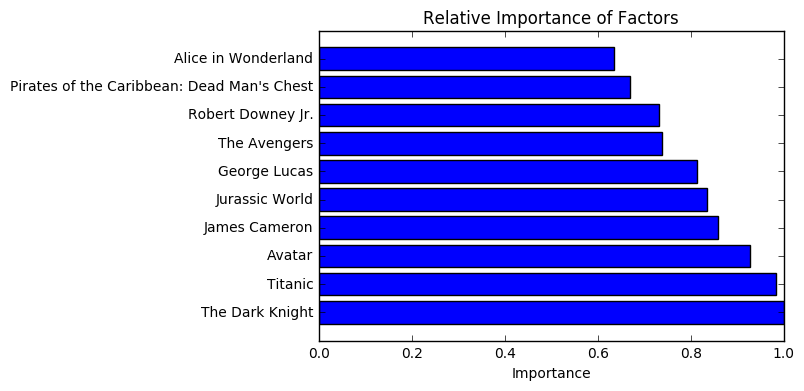

In [384]:
# relative weight
rel_tit = [x / top20_tit[0] for x in top20_tit]
plt.figure()
plt.barh(range(10), np.array(rel_tit)[[0,1,3,4,5,7,8,9,10,11]], align = "center")
plt.yticks(range(10), final_top_tit[:10])
plt.ylim([-1,10])
plt.xlabel("Importance")
plt.title("Relative Importance of Factors")

These are mostly movie titles. This makes sense due to their uniqueness. Let's drop those from the dataset and see what the best predictors are, then.

In [365]:
# top 20 without movie titles
no_title = pre_filled.copy()
for name in pre_filled.columns:
    if name in data['movie_title'].values:
        del no_title[name]

In [366]:
# Unweighted linear regression
lr = LinearRegression()
lr.fit(no_title, y)
lr_scre = lr.score(no_title, y)

# most weighted variables
coeffs = lr.coef_
abs_coeffs = [np.abs(x) for x in coeffs]

# 20 top coefficients
import heapq
top20 = heapq.nlargest(20, abs_coeffs[0])

# what are the top coefficients
top = []
for i in top20:
    index = list(abs_coeffs[0]).index(i)
    top.append(no_title.columns[index])
    
# cut end of movie title text
final_top = []
for i in top:
    var = i.split('\xc2\xa0')[0]
    if var not in final_top:
        final_top.append(var)
        
final_top

['Ah-sung Ko',
 'Doona Bae',
 'Kang-ho Song',
 'Yeong-ae Lee',
 'Ji-tae Yu',
 'Joon-ho Bong',
 'Korean',
 'Jean Simmons',
 'Guillaume Canet',
 'Woo-sung Jung',
 'Je-kyu Kang',
 'Dong-gun Jang',
 'Bin Won',
 'Billy Crudup',
 'Hong-jin Na',
 'Jun Kunimura',
 'Jung-min Hwang']

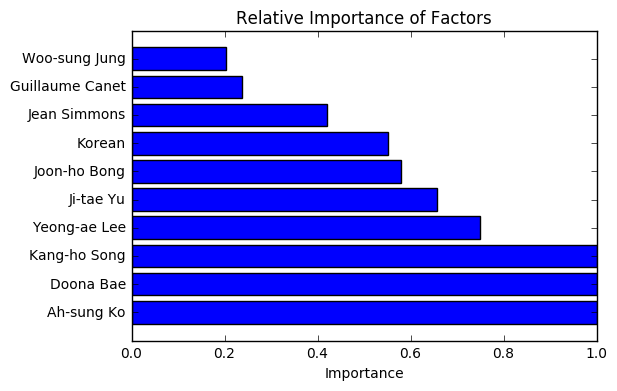

In [387]:
# relative importance
rel = [x / top20[0] for x in top20]
plt.figure()
plt.barh(range(10), rel[:10], align = "center")
plt.yticks(range(10), final_top[:10])
plt.ylim([-1,10])
plt.xlabel("Importance")
plt.title("Relative Importance of Factors")

Now, actor names (many of whom are Korean) dominate the list, perhaps, again, due to uniqueness.

With the size of our dataset, we should try some regularized linear regression techniques.

In [226]:
# lasso
lass = linear_model.Lasso()
lass.fit(x_train, y_train)
lass_scre = lass.score(x_test, y_test)

print "The R^2 value for lasso is " + str(lass_scre)

The R^2 value for lasso is 0.107892828121


In [227]:
# ridge
ridge = linear_model.Ridge()
ridge.fit(x_train, y_train)
ridge_scre = ridge.score(x_test, y_test)

print "The R^2 value for lasso is " + str(ridge_scre)

The R^2 value for lasso is 0.422573709012


In [332]:
# get various results
lrs = []
las = []
rids = []
for i in range(10):
    # train and test split
    x_train, x_test, y_train, y_test = train_test_split(pre_filled, y, test_size=0.3)
    
    # linear regression
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    lrs.append(lr.score(x_test, y_test))
    
    # lasso
    lass = linear_model.Lasso()
    lass.fit(x_train, y_train)
    las.append(lass.score(x_test, y_test))
    
    # ridge
    ridge = linear_model.Ridge()
    ridge.fit(x_train, y_train)
    rids.append(ridge.score(x_test, y_test))

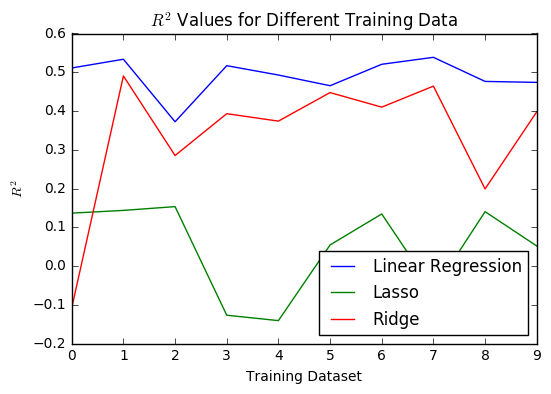

In [333]:
# plot r2 values
plt.figure()
plt.plot(lrs, label = "Linear Regression")
plt.plot(las, label = "Lasso")
plt.plot(rids, label = "Ridge")
plt.xlabel("Training Dataset")
plt.ylabel("$R^2$")
plt.title("$R^2$ Values for Different Training Data")
plt.legend(loc = "best")

Linear regression is the most consistently good across datasets, while lasso performs quite poorly. All of these models took a really long time to build. We need dimensionality reduction.

In [7]:
# pca
pca = PCA(n_components = 100)
pca.fit(pre_filled)
new_x = pca.transform(pre_filled)

In [241]:
# get various results
lrs = []
las = []
rids = []
for i in range(100):
    # train and test split
    x_train, x_test, y_train, y_test = train_test_split(new_x, y, test_size=0.3)
    
    # linear regression
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    lrs.append(lr.score(x_test, y_test))
    
    # lasso
    lass = linear_model.Lasso()
    lass.fit(x_train, y_train)
    las.append(lass.score(x_test, y_test))
    
    # ridge
    ridge = linear_model.Ridge()
    ridge.fit(x_train, y_train)
    rids.append(ridge.score(x_test, y_test))

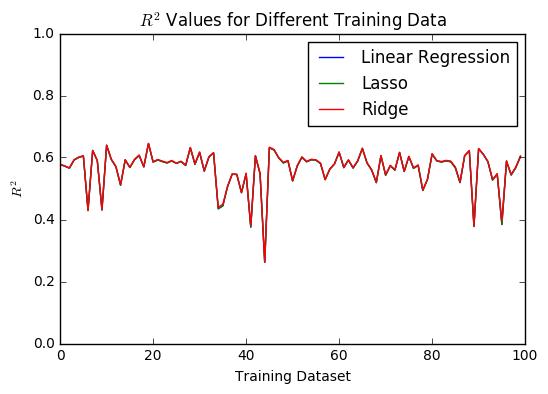

In [245]:
# plot r2 values
plt.figure()
plt.plot(lrs, label = "Linear Regression")
plt.plot(las, label = "Lasso")
plt.plot(rids, label = "Ridge")
plt.xlabel("Training Dataset")
plt.ylabel("$R^2$")
plt.ylim([0,1])
plt.title("$R^2$ Values for Different Training Data")
plt.legend(loc = "best")

In [246]:
print np.mean(rids)
print np.mean(las)
print np.mean(lrs)

0.566067349822
0.564610317552
0.564610141482


Transforming our dataset with 100 PCA components, we see that the regularized linear regression methods perform nearly identically to regular linear regression, so there seems to be little point using a regularized method.

Let's find the optimal number of PCA components to use.

In [368]:
# test different values for pca
x_train, x_test, y_train, y_test = train_test_split(pre_filled, y, test_size=0.3)
lrs = []
for i in range(100):
    pca = PCA(n_components = i + 1)
    pca.fit(x_train)
    x_tr = pca.transform(x_train)
    x_tst = pca.transform(x_test)
    
    # linear regression
    lr = LinearRegression()
    lr.fit(x_tr, y_train)
    lrs.append(lr.score(x_tst, y_test))

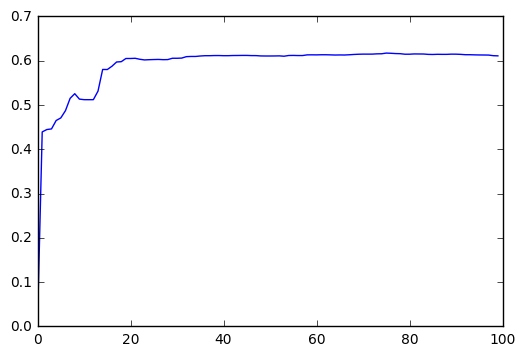

In [369]:
# plot results
plt.figure()
plt.plot(lrs, label = "Linear Regression")

In [370]:
# differences in r^2
diff = []
for i in range(len(lrs) - 1):
    diff.append(lrs[i + 1] - lrs[i])

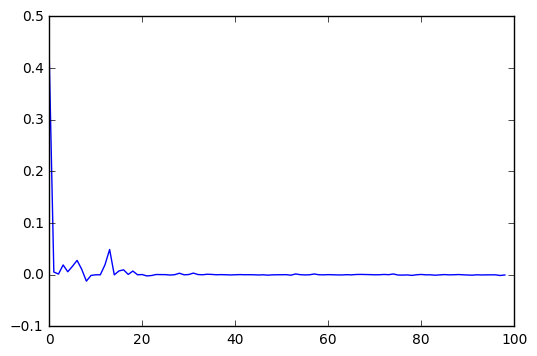

In [371]:
# plot the differences
plt.figure()
plt.plot(diff)

The $R^2$ value stabilizes around 20 components, so let's use that for our final dataset.

In [8]:
# pca with 20 components
pca_final = PCA(n_components = 20)
pca_final.fit(pre_filled)
x_final = pca_final.transform(pre_filled)

In [9]:
x_final.shape

(4159, 20)

Let's try various models on our final dataset, using regression trees as well.

In [336]:
# run 100 models
lr_score = []
tree_score = []
lass_score = []
ridge_score = []
for i in range(100):
    # split data
    x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.3)
    
    # linear regression
    lin_reg = LinearRegression()
    lin_reg.fit(x_train, y_train)
    lr_score.append(lin_reg.score(x_test, y_test))
    
    # regression tree
    rt = DecisionTreeRegressor(max_depth = 5)
    rt.fit(x_train, y_train)
    tree_score.append(rt.score(x_test, y_test))
    
    # lasso
    lass = linear_model.Lasso(alpha = 5)
    lass.fit(x_train, y_train)
    lass_score.append(lass.score(x_test, y_test))
    
    # ridge
    ridge = linear_model.Ridge(alpha = 5)
    ridge.fit(x_train, y_train)
    ridge_score.append(ridge.score(x_test, y_test))

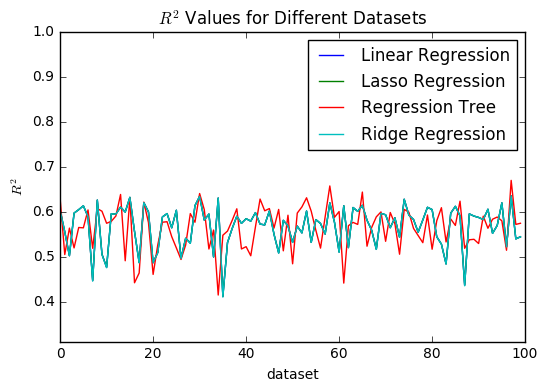

In [342]:
# plot tree and lin reg score
plt.figure()
plt.plot(lr_score, label = "Linear Regression")
plt.plot(lass_score, label = "Lasso Regression")
plt.plot(tree_score, label = "Regression Tree")
plt.plot(ridge_score, label = "Ridge Regression")
plt.legend(loc = "best")
plt.ylim([np.min(lr_score) - 0.1,1])
plt.ylabel("$R^2$")
plt.xlabel("dataset")
plt.title("$R^2$ Values for Different Datasets")

In [285]:
# mean and variation
print "The mean R^2 value for regression trees is " + str(np.mean(tree_score))
print "The mean R^2 value for linear regression is " + str(np.mean(lr_score))
print "The mean R^2 value for lasso regression is " + str(np.mean(lass_score))
print "The mean R^2 value for ridge regression is " + str(np.mean(ridge_score))
print "The variation in the R^2 value for regression trees is " + str(np.var(tree_score))
print "The variation in the R^2 value for linear regression is " + str(np.var(lr_score))
print "The variation in the R^2 value for lasso regression is " + str(np.var(ridge_score))
print "The variation in the R^2 value for ridge regression is " + str(np.var(lass_score))

The mean R^2 value for regression trees is 0.556719726483
The mean R^2 value for linear regression is 0.550622836326
The mean R^2 value for lasso regression is 0.550622790526
The mean R^2 value for ridge regression is 0.550372533169
The variation in the R^2 value for regression trees is 0.00208628898619
The variation in the R^2 value for linear regression is 0.00841694170186
The variation in the R^2 value for lasso regression is 0.00853074696166
The variation in the R^2 value for ridge regression is 0.00841696146033


There is little to no difference between types of linear regression.

Regression trees are much more consistent. While linear regression sometimes outperforms these models, regression trees show significantly less variation.

Let's see if adjusting the alpha parameter for the regularized regressions change anything.

In [17]:
# different alpha values for lasso and ridge
lasso_alpha = []
ridge_alpha = []
lin_reg = []
x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.3)
for i in range(100):
    # lasso
    lass = linear_model.Lasso(alpha = i + 1)
    lass.fit(x_train, y_train)
    lasso_alpha.append(lass.score(x_test, y_test))
    
    # ridge
    ridge = linear_model.Ridge(alpha = i + 1)
    ridge.fit(x_train, y_train)
    ridge_alpha.append(ridge.score(x_test, y_test))
    
    # linear regression
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    lin_reg.append(lr.score(x_test, y_test))

/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


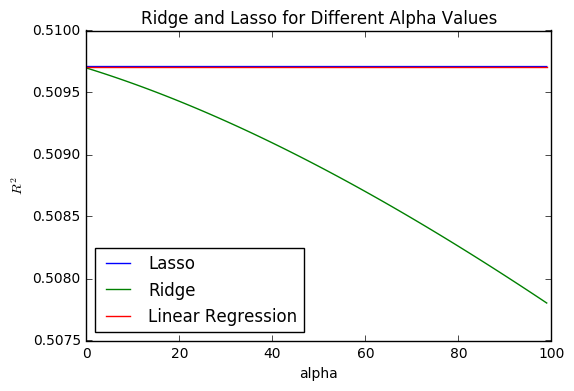

In [18]:
# plot the results
plt.figure()
plt.plot(lasso_alpha, label = "Lasso")
plt.plot(ridge_alpha, label = "Ridge")
plt.plot(lin_reg, label = "Linear Regression")
plt.title("Ridge and Lasso for Different Alpha Values")
plt.xlabel("alpha")
plt.ylabel("$R^2$")
plt.legend(loc = "best")

We see no benefits from increasing the alpha value, so let's proceed with regression trees.

In [186]:
# test different depths
score_train = []
score_test = []
x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.3)
for i in range(20):
    rt = DecisionTreeRegressor(max_depth = i + 1)
    rt.fit(x_train, y_train)
    score_test.append(rt.score(x_test, y_test))
    score_train.append(rt.score(x_train, y_train))

(1, 20)

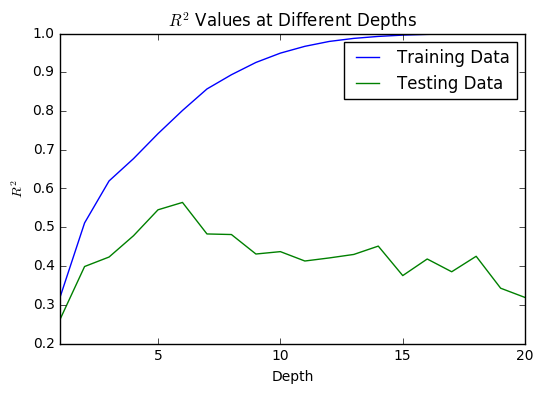

In [187]:
# plot for different depths
plt.figure()
plt.plot(range(1,21), score_train, label = "Training Data")
plt.plot(range(1,21), score_test, label = "Testing Data")
plt.xlabel("Depth")
plt.ylabel("$R^2$")
plt.title("$R^2$ Values at Different Depths")
plt.legend(loc = "best")
plt.xlim([1, 20])

In [188]:
# best depth
max_r2 = np.max(score_test)
depth = score_test.index(max_r2) + 1
print "The max R^2 is found when depth = " + str(depth)

The max R^2 is found when depth = 6


Our final regression tree model will have depth 6.

In [396]:
x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.3)
rt = DecisionTreeRegressor(max_depth = depth)
rt.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [397]:
print rt.score(x_final, y)
print rt.score(x_test, y_test)

0.719644590512
0.570733033849


In [400]:
scores = []
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.3)
    scores.append(rt.score(x_test, y_test))
    
print np.mean(scores)

0.71466619462


We see quite good results from this model, with an $R^2$ value of about 0.72 for the full dataset and 0.57 for the testing data.

Finally, let's see if we can improve by using random forrests.

In [29]:
# test random forests
scores = []
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.3)
    rf = RandomForestRegressor(max_depth = 6)
    rf.fit(x_train, np.ravel(y_train))
    scores.append(rf.score(x_test, np.ravel(y_test)))

0.664174554023


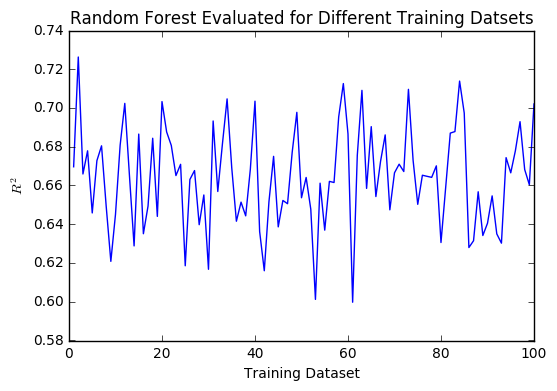

In [32]:
# plot the results
plt.figure()
plt.plot(range(1,101), scores)
plt.xlabel("Training Dataset")
plt.ylabel("$R^2$")
plt.title("Random Forest Evaluated for Different Training Datsets")
print np.mean(scores)

The results here are quite good, with an average $R^2$ value of 0.664174554023 for the testing data. This is an improvement over the single regression tree model. Let's see if we can tweak some parameters to get even better performance.

In [35]:
# test random forests for different depths
scores = []
x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.3)
for i in range(100):
    rf = RandomForestRegressor(max_depth = i + 1)
    rf.fit(x_train, np.ravel(y_train))
    scores.append(rf.score(x_test, np.ravel(y_test)))

The best max depth is 26


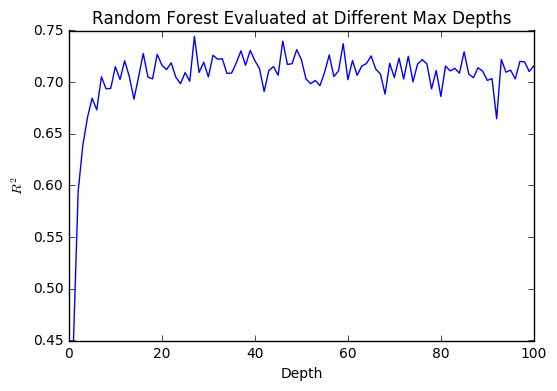

In [39]:
# plot the results
plt.figure()
plt.plot(range(1,101), scores)
plt.xlabel("Depth")
plt.ylabel("$R^2$")
plt.title("Random Forest Evaluated at Different Max Depths")
print "The best max depth is " + str(list(scores).index(np.max(scores)))

We see here that we should use 26 as our max depth.

In [40]:
# test random forests for different max features
scores_n = []
scores_sqrt = []
scores_p2 = []
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.3)
    
    # n features
    rf_n = RandomForestRegressor(max_depth = 26, max_features = 20)
    rf_n.fit(x_train, np.ravel(y_train))
    scores_n.append(rf_n.score(x_test, np.ravel(y_test)))
    
    # sqrt(n) features
    rf_sqrt = RandomForestRegressor(max_depth = 26, max_features = int(np.sqrt(20)))
    rf_sqrt.fit(x_train, np.ravel(y_train))
    scores_sqrt.append(rf_sqrt.score(x_test, np.ravel(y_test)))
    
    # n features
    rf_p2 = RandomForestRegressor(max_depth = 26, max_features = int(20 / 2))
    rf_p2.fit(x_train, np.ravel(y_train))
    scores_p2.append(rf_p2.score(x_test, np.ravel(y_test)))

N: 0.682531901889 sqrt(p): 0.666913047317 scores_p2: 0.681156606203


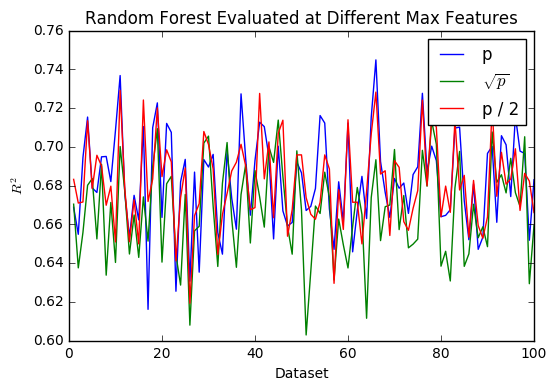

In [43]:
# plot the results
plt.figure()
plt.plot(range(1,101), scores_n, label = "p")
plt.plot(range(1,101), scores_sqrt, label = "$\sqrt{p}$")
plt.plot(range(1,101), scores_p2, label = "p / 2")
plt.legend(loc = "best")
plt.xlabel("Dataset")
plt.ylabel("$R^2$")
plt.title("Random Forest Evaluated at Different Max Features")
print "N: " + str(np.mean(scores_n)) + " sqrt(p): " + str(np.mean(scores_sqrt)) + " scores_p2: " + str(np.mean(scores_p2))

We will keep $p$ features as that performs the best.

In [46]:
# forests with different number of trees
scores = []
x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size=0.3)
for i in range(50):
    
    # n features
    rf = RandomForestRegressor(max_depth = 26, max_features = 20, n_estimators = i + 1)
    rf.fit(x_train, np.ravel(y_train))
    scores.append(rf.score(x_test, np.ravel(y_test)))

The best number of trees is 37


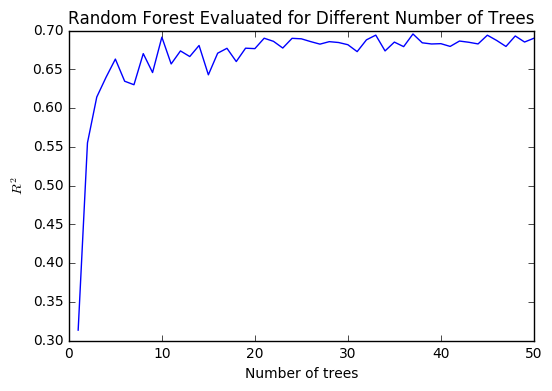

In [54]:
# plot the results
plt.figure()
plt.plot(range(1,51), scores)
plt.xlabel("Number of trees")
plt.ylabel("$R^2$")
plt.title("Random Forest Evaluated for Different Number of Trees")
print "The best number of trees is " + str(list(scores).index(np.max(scores)) + 1)

We have our final model - a random forest with max depth of 26 using 20 features and 36 trees.

In [58]:
# final fitting
final_forest = RandomForestRegressor(max_depth = 26, max_features = 20, n_estimators = 37)
final_forest.fit(x_train, np.ravel(y_train))
print "Full dataset R^2: " + str(final_forest.score(x_final, np.ravel(y)))
print "Testing R^2: " + str(final_forest.score(x_test, np.ravel(y_test)))

Full dataset R^2: 0.866030213391
Testing R^2: 0.690234908898


Finally, let's do some error analysis to see where our model is week.

In [85]:
# get predictions
predictions = final_forest.predict(x_final)

# absolute errors
errors = np.abs(predictions - np.ravel(y))

# biggest errors
import heapq
top20_errors = heapq.nlargest(20, errors)

# what are the top coefficients
top_errors = []
for i in top20_errors:
    index = list(top20_errors).index(i)
    top_errors.append(x.iloc[index].movie_title)

final_err = []
for i in top_errors:
    var = i.split('\xc2\xa0')[0]
    final_err.append(var)

In [86]:
final_err

['Avatar',
 "Pirates of the Caribbean: At World's End",
 'Spectre',
 'The Dark Knight Rises',
 'John Carter',
 'Spider-Man 3',
 'Tangled',
 'Avengers: Age of Ultron',
 'Harry Potter and the Half-Blood Prince',
 'Batman v Superman: Dawn of Justice',
 'Superman Returns',
 'Quantum of Solace',
 "Pirates of the Caribbean: Dead Man's Chest",
 'The Lone Ranger',
 'Man of Steel',
 'The Chronicles of Narnia: Prince Caspian',
 'The Avengers',
 'Pirates of the Caribbean: On Stranger Tides',
 'Men in Black 3',
 'The Hobbit: The Battle of the Five Armies']

We see that our biggest errors are when predicting movies that make quite a bit of money. This makes sense, as the average movie makes less. Next steps would be to identify what causes these errors and make relative improvements.